In [41]:
import pandas as pd
import numpy as np
from pandas import read_csv
from datetime import datetime
from pandas import DataFrame
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [42]:
def parse(x):
      return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']],
                 index_col=0, date_parser=parse)

In [43]:
dataset.head(10)

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0
2010-01-01 05:00:00,6,NaN,-19,-10.0,1017.0,NW,16.10,0,0
2010-01-01 06:00:00,7,NaN,-19,-9.0,1017.0,NW,19.23,0,0
2010-01-01 07:00:00,8,NaN,-19,-9.0,1017.0,NW,21.02,0,0
2010-01-01 08:00:00,9,NaN,-19,-9.0,1017.0,NW,24.15,0,0


In [44]:
# 데이터 전처리
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]
dataset.to_csv('pollution.csv')

In [45]:
# 데이터 표준화 및 정규화
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

In [46]:
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4]) #범주형 wind_dir 변수를 숫자로 인코딩 해 준다
values = values.astype('float32')

In [47]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values) #값을 0~1로 떨어뜨린다

In [48]:
scaled

array([[0.12977867, 0.35294122, 0.24590163, ..., 0.00229001, 0.        ,
        0.        ],
       [0.14889336, 0.36764708, 0.24590163, ..., 0.00381099, 0.        ,
        0.        ],
       [0.15995975, 0.4264706 , 0.22950819, ..., 0.00533197, 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.41399646, 0.        ,
        0.        ],
       [0.00804829, 0.2647059 , 0.24590163, ..., 0.4208665 , 0.        ,
        0.        ],
       [0.01207243, 0.2794118 , 0.26229507, ..., 0.42621556, 0.        ,
        0.        ]], dtype=float32)

In [49]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [50]:
reframed = series_to_supervised(scaled, 1, 1) #t-1시점,t시점 데이터를 한 행으로 둔다     
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

In [51]:
# series_to_supervised함수의 n_in,n_out에 따라 가져올 시점의 데이터가 달라진다 
# (만약 n_in = 3, n_out = 3이라면 t-3 , t-2 , t-1 , t , t+1 , t+2 시점의 데이터가 하나의 행이 된다)
print(reframed.shape)
reframed

(43799, 9)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658
...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048


In [52]:
# 데이터 train/test split 
# LSTM을 사용하기 위해 모델학습용 데이터(train)와 정확도를 확인하기 위한 데이터(test)를 구분시켜 줍니다


In [53]:
values = reframed.values
n_train_hours = 365 * 24 #1년치 데이터만 가져온다
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


In [54]:
print(train.shape)
print(test.shape)
# train.head(5)
# test.head(5)
print(train)
print("")
print(test)


(8760, 9)
(35039, 9)
[[0.12977867 0.35294122 0.24590163 ... 0.         0.         0.14889336]
 [0.14889336 0.36764708 0.24590163 ... 0.         0.         0.15995975]
 [0.15995975 0.4264706  0.22950819 ... 0.         0.         0.18209255]
 ...
 [0.         0.32352942 0.22950819 ... 0.         0.         0.        ]
 [0.         0.32352942 0.16393442 ... 0.         0.         0.        ]
 [0.         0.33823532 0.1967213  ... 0.         0.         0.0362173 ]]

[[0.0362173  0.33823532 0.1967213  ... 0.         0.         0.03118712]
 [0.03118712 0.33823532 0.1967213  ... 0.         0.         0.02012072]
 [0.02012072 0.33823532 0.1967213  ... 0.         0.         0.01911469]
 ...
 [0.01006036 0.2647059  0.26229507 ... 0.         0.         0.01006036]
 [0.01006036 0.2647059  0.26229507 ... 0.         0.         0.00804829]
 [0.00804829 0.2647059  0.24590163 ... 0.         0.         0.01207243]]


In [55]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


In [56]:
print(train_X.shape)
print(train_y.shape)
# train_X

(8760, 8)
(8760,)


In [57]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [58]:
print(train_X.shape)
print(train_y.shape)


(8760, 1, 8)
(8760,)


In [68]:
# 모델 빌드 
# LSTM 모델을 구축하고 train데이터를 이용해 학습
from keras.layers import LSTM
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 

import math


In [60]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [61]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
        validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
122/122 - 1s - loss: 0.0550 - val_loss: 0.0509
Epoch 2/50
122/122 - 0s - loss: 0.0378 - val_loss: 0.0478
Epoch 3/50
122/122 - 0s - loss: 0.0227 - val_loss: 0.0403
Epoch 4/50
122/122 - 0s - loss: 0.0177 - val_loss: 0.0363
Epoch 5/50
122/122 - 0s - loss: 0.0157 - val_loss: 0.0227
Epoch 6/50
122/122 - 0s - loss: 0.0150 - val_loss: 0.0166
Epoch 7/50
122/122 - 0s - loss: 0.0150 - val_loss: 0.0151
Epoch 8/50
122/122 - 0s - loss: 0.0148 - val_loss: 0.0151
Epoch 9/50
122/122 - 0s - loss: 0.0147 - val_loss: 0.0151
Epoch 10/50
122/122 - 0s - loss: 0.0148 - val_loss: 0.0150
Epoch 11/50
122/122 - 0s - loss: 0.0148 - val_loss: 0.0144
Epoch 12/50
122/122 - 0s - loss: 0.0147 - val_loss: 0.0144
Epoch 13/50
122/122 - 0s - loss: 0.0146 - val_loss: 0.0142
Epoch 14/50
122/122 - 0s - loss: 0.0146 - val_loss: 0.0141
Epoch 15/50
122/122 - 0s - loss: 0.0146 - val_loss: 0.0140
Epoch 16/50
122/122 - 0s - loss: 0.0146 - val_loss: 0.0139
Epoch 17/50
122/122 - 0s - loss: 0.0146 - val_loss: 0.0138
Epoch 

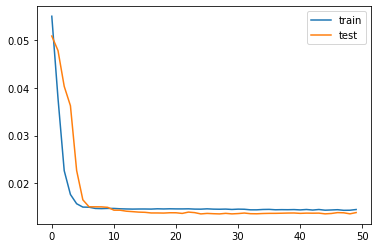

In [62]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [63]:
# 예측 및 모델평가
# 학습이 끝난 모델로 test데이터를 예측
# 실제 결과 비교 

In [64]:
# make a prediction
yhat = model.predict(test_X)


In [65]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [69]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))

In [70]:
# RMSE(Root Mean)
# 예측 값과 실제값을 뺀 후 제곱시킨 값들을 다 더하고 n 으로 나눈후 루트를 씌운 값 
# 모델의 예측 값과 실제 값의 차이

rmse

26.892751677235214

In [ ]:
# LSTM 모델을 활용시 주변시점 데이터를 t 시점과 동일 선상에 오게끔 변형한 후 분석하는 과정이 필요하다?